In [160]:
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from astropy.table import Table, Column

from astropy.io.votable import parse_single_table
from sklearn.cluster import AffinityPropagation

%matplotlib inline

In [243]:
cat_file='data/NOAO_NGC6744_april_2016.xml'
cat_data = parse_single_table(cat_file).to_table(use_names_over_ids=True)
for i in range(len(cat_data)):
    cat_data['filter'][i]=str(cat_data['filter'][i][0])

print 'Column names: ', str(cat_data.colnames)

Column names:  ['reference', 'dtpropid', 'surveyid', 'release_date', 'start_date', 'date_obs', 'dtpi', 'ra', 'dec', 'telescope', 'instrument', 'filter', 'exposure', 'obstype', 'obsmode', 'proctype', 'prodtype', 'seeing', 'depth', 'dtacqnam', 'archive_file', 'filesize', 'md5sum', 'noao_id']


In [244]:
# Function for plotting DECam footprint
def plot_decam_footprint(ra, dec, title='DECam'):

    ra=np.asarray(ra)
    dec=np.asarray(dec)
    
    decam_corners=np.array([[1652.0,-2994.2],[1652.0,-3521.1],[585.1,-3521.1], #shape 1
                        [585.1,-2994.2],[-583.4,-2991.8], #Missing chip South
                        [-583.4,-3521.6],[-1651.3,-3521.6],[-1651.3,-2991.8], #shape 2
                        [-2210.7,-2930.6],[-2210.7,-2400.3], #shape 6
                        [-2769.5,-2339.3],[-2769.5,-1808.5], #shape 11
                        [-3322.1,-1746.9],[-3322.1,-1217.0], # shape 17
                        [-3329.6,-1156.4],[-3329.6,-626.1], # shape 23
                        [-3887.0,-564.0],[-3887.0,-33.4], # shape 30
                        [-3886.2,28.5],[-3886.2,557.9], # shape 37
                        [-3328.0,621.2],[-3328.0,1150.2], # shape 43
                        [-3328.0,1212.0],[-3328.0,1741.0], #shape 49
                        [-2769.6,1805.1],[-2769.6,2333.2], #shape 54
                        [-2210.4,2397.3],[-2210.4,2925.0], #shape 58
                        [-1651.7,2989.0],[-1651.7,3516.3],[-583.1,3516.3], #shape 60
                        [-583.1,2989.0],[583.8,2987.6], # Missing chip North
                        [583.8,3517.3],[1652.8,3517.3],[1652.8,2987.6], #shape 59
                        [2211.8,2926.8],[2211.8,2396.0], #shape 55
                        [2770.8,2335.2],[2770.8,1803.6], #shape 50
                        [3330.1,1743.0],[3330.1,1212.0], #shape 44
                        [3329.7,1151.8],[3329.7,620.6], #shape 38
                        [3887.7,558.8],[3887.7,29.4], #shape 31
                        [3887.1,-32.9],[3887.1,-562.9], #shape 24
                        [3328.7,-626.1],[3328.7,-1155.1], #shape 18
                        [3328.0,-1217.6],[3328.0,-1745.7], #shape 12
                        [2769.3,-1810.1],[2769.3,-2336.9], #shape 7
                        [2210.3,-2401.9],[2210.3,-2928.9], #shape 3
                        [1652.0,-2994.2],[1652.0,-3521.1] #shape 1
                        ])
    decam_corners[:,0]=decam_corners[:,0]*-1
    for i in range(decam_corners.shape[0]-1):
        if np.abs(decam_corners[i,1]-decam_corners[i+1,1])<100:
            decam_corners[i:i+2,1]=np.mean(decam_corners[i:i+2,1])
            i=i+1
    
    patches=[]
    for i in range(len(ra)):
        corners=decam_corners/3600. # Convert from arcseconds to degrees
        corners[:,0]=ra[i]+corners[:,0]/np.cos(np.radians(dec[i]))
        corners[:,1]=dec[i]+corners[:,1]
        polygon=Polygon(corners,closed=True)
        patches.append(polygon)
    
    p = PatchCollection(patches, alpha=0.1)
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xlim(max(ra)+1.2/np.cos(np.radians(min(dec))), min(ra)-1.2/np.cos(np.radians(min(dec))))
    ax.set_ylim(min(dec)-1.2, max(dec)+1.2)
    ax.add_collection(p)
    ax.set_title(title)
    ax.set_xlabel('R.A. (deg)')
    ax.set_ylabel('Dec (deg)')
    plt.show()
    
    coo=np.concatenate((np.transpose([ra]), np.transpose([dec])), axis=1)
    af = AffinityPropagation(affinity="euclidean", damping=0.9).fit(coo)
    cluster_centers_indices = af.cluster_centers_indices_
    labels = af.labels_
    n_clusters = len(cluster_centers_indices)
    print 'Number of tiles: ', n_clusters
    for i in range(n_clusters):
        class_members = labels == i
        cluster_center=[np.median(coo[class_members,0]),np.median(coo[class_members,1])]
        print 'Tile '+str(i+1)+' coo :', ['{:.4f}'.format(x) for x in cluster_center]

Total exposure:  5400.0


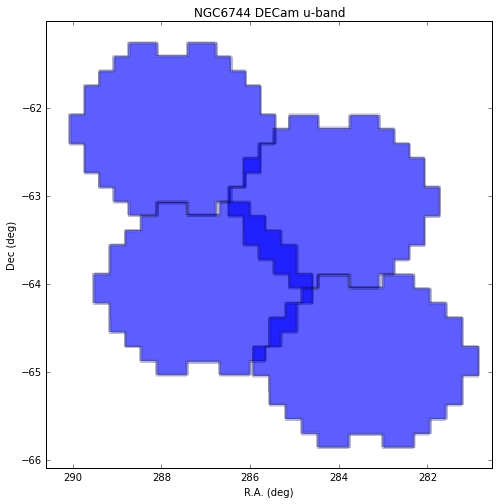

Number of tiles:  4
Tile 1 coo : ['287.7645', '-62.2343']
Tile 2 coo : ['287.0723', '-64.0398']
Tile 3 coo : ['283.4002', '-64.8641']
Tile 4 coo : ['284.1164', '-63.0549']


In [234]:
gv=((cat_data['filter']=='u') & (cat_data['dtpropid']!='2014A-0611') & (cat_data['dtpropid']!='2014A-0321'))
print 'Total exposure: ', np.sum(cat_data['exposure'][gv])/4
plot_decam_footprint(cat_data['ra'][gv], cat_data['dec'][gv], title='NGC6744 DECam u-band')

Total exposure:  5250.0


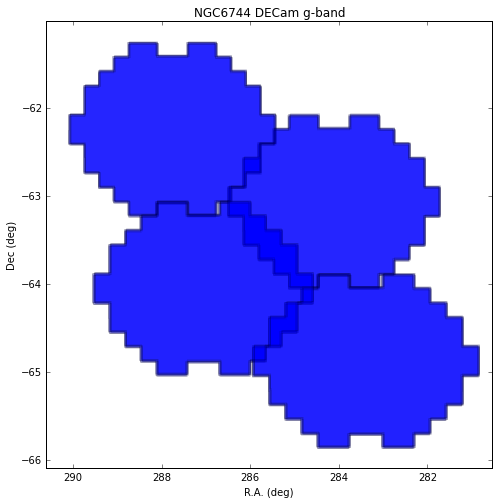

Number of tiles:  4
Tile 1 coo : ['287.0628', '-64.0423']
Tile 2 coo : ['283.3937', '-64.8651']
Tile 3 coo : ['284.1131', '-63.0584']
Tile 4 coo : ['287.7642', '-62.2376']


In [235]:
gv=((cat_data['filter']=='g') & (cat_data['dtpropid']!='2014A-0611') & (cat_data['dtpropid']!='2014A-0321'))
print 'Total exposure: ', np.sum(cat_data['exposure'][gv])/4
plot_decam_footprint(cat_data['ra'][gv], cat_data['dec'][gv], title='NGC6744 DECam g-band')

Total exposure:  4725.0


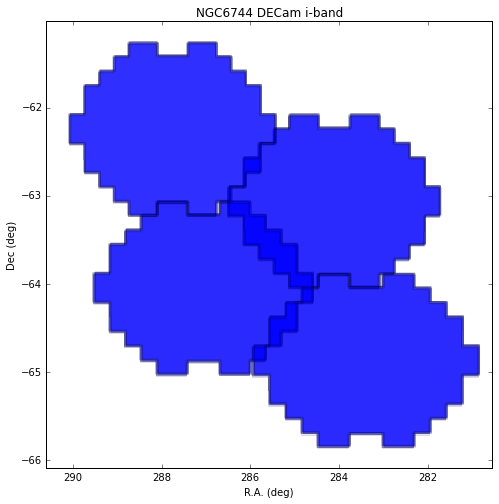

Number of tiles:  4
Tile 1 coo : ['287.0686', '-64.0413']
Tile 2 coo : ['284.1170', '-63.0560']
Tile 3 coo : ['287.7684', '-62.2364']
Tile 4 coo : ['283.3976', '-64.8642']


In [236]:
gv=((cat_data['filter']=='i') & (cat_data['dtpropid']!='2014A-0611') & (cat_data['dtpropid']!='2014A-0321'))
print 'Total exposure: ', np.sum(cat_data['exposure'][gv])/4
plot_decam_footprint(cat_data['ra'][gv], cat_data['dec'][gv], title='NGC6744 DECam i-band')

Total exposure:  425.25


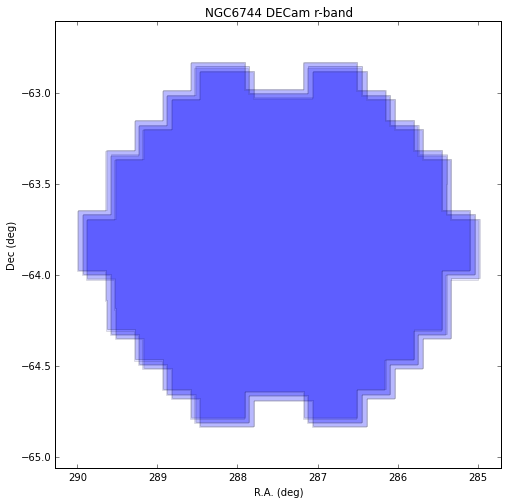

Number of tiles:  3
Tile 1 coo : ['287.4291', '-63.8524']
Tile 2 coo : ['287.4857', '-63.8283']
Tile 3 coo : ['287.5432', '-63.8042']


In [237]:
gv=((cat_data['filter']=='r') & (cat_data['dtpropid']!='2014A-0611'))
print 'Total exposure: ', np.sum(cat_data['exposure'][gv])/4
plot_decam_footprint(cat_data['ra'][gv], cat_data['dec'][gv], title='NGC6744 DECam r-band')

Total exposure:  2475.0


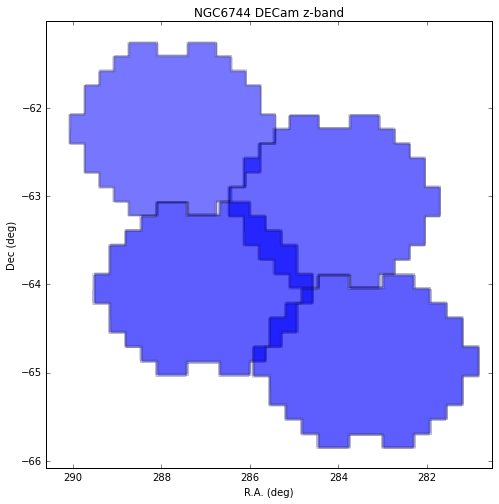

Number of tiles:  4
Tile 1 coo : ['287.0642', '-64.0415']
Tile 2 coo : ['283.3925', '-64.8646']
Tile 3 coo : ['284.1032', '-63.0550']
Tile 4 coo : ['287.7584', '-62.2327']


In [238]:
gv=((cat_data['filter']=='z') & (cat_data['dtpropid']!='2014A-0611') & (cat_data['dtpropid']!='2014A-0321'))
print 'Total exposure: ', np.sum(cat_data['exposure'][gv])/4
plot_decam_footprint(cat_data['ra'][gv], cat_data['dec'][gv], title='NGC6744 DECam z-band')

Total exposure:  1350.0


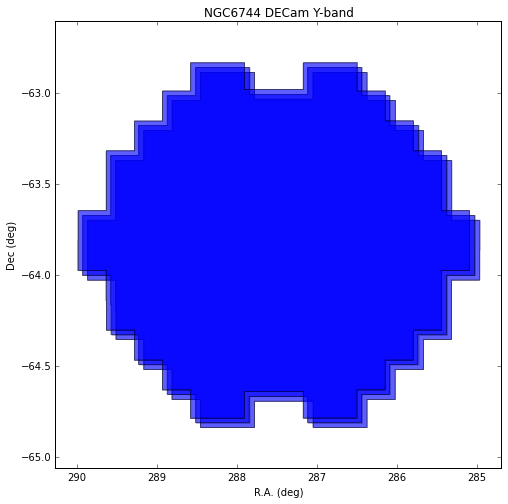

Number of tiles:  3
Tile 1 coo : ['287.4220', '-63.8588']
Tile 2 coo : ['287.4870', '-63.8318']
Tile 3 coo : ['287.5449', '-63.8060']


In [239]:
gv=((cat_data['filter']=='Y'))
print 'Total exposure: ', np.sum(cat_data['exposure'][gv])/4
plot_decam_footprint(cat_data['ra'][gv], cat_data['dec'][gv], title='NGC6744 DECam Y-band')